#GpyOptのインストール

In [1]:
!pip install GPY
!pip install gpyopt

    100% |████████████████████████████████| 880kB 21.0MB/s 
    100% |████████████████████████████████| 71kB 19.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/97/82/1d/32a361e1ff2b4d9129a60343831dd99cdc74440e2db1c55264
  Stored in directory: /root/.cache/pip/wheels/a9/fc/74/3bbd263c43ed98d67343df24cebf0a0ee34afee40d769fda9c
Successfully built GPY paramz
    100% |████████████████████████████████| 61kB 5.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/33/1d/87/dc02440831ba986b1547dd11a7dcd44e893b0527083066d869
Successfully built gpyopt


#cifar10

In [2]:
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.applications.resnet50 import ResNet50
from keras.layers import Input, GlobalAveragePooling2D, Dense
from keras.layers import Activation, BatchNormalization, Conv2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.preprocessing.image import array_to_img
from keras import backend as K
from keras.preprocessing.image import save_img

import cv2
import os
import GPy
import GPyOpt
import numpy as np
import glob
from xml.dom.minidom import parseString
import matplotlib.pyplot as plt

classes = 10
inputs = (32,32,3)
input_tensor = Input(shape=inputs)

# データロード
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

print(x_train.shape)
print(x_test.shape)
print(Y_train.shape)
print(Y_test.shape)
print(np.max(x_train))
print(np.min(x_train))

Using TensorFlow backend.


170500096/170498071 [==============================] - 51s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 10)
(10000, 10)
1.0
0.0


#CNNの学習(10分かかる)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
391/390 [==============================] - 63s 160ms/step - loss: 1.5391 - acc: 0.4381 - val_loss: 1.9915 - val_acc: 0.4391
Epoch 2/10
391/390 [==============================] - 56s 143ms/step - loss: 1.1192 - acc: 0.6010 - val_loss: 1.3616 - val_acc: 0.5786
Epoch 3/10
391/390 [==============================] - 56s 143ms/step - loss: 0.9096 - acc: 0.6801 - val_loss: 1.4812 - val_acc: 0.5636
Epoch 4/10
391/390 [==============================] - 56s 143ms/step - loss: 0.7886 - acc: 0.7239 - val_loss: 0.7559 - val_acc: 0.7420
Epoch 5/10
391/390 [==============================] - 56s 143ms/step - loss: 0.6983 - acc: 0.7564 - val_loss: 1.0151 - val_acc: 0.7044
Epoch 6/10
391/390 [==============================] - 56s 144ms/step - loss: 0.6417 - acc: 0.7769 - val_loss: 0.9328 - val_acc: 0.7231
Epoch 7/10
391/390 [==============================] - 56s 143ms/step -

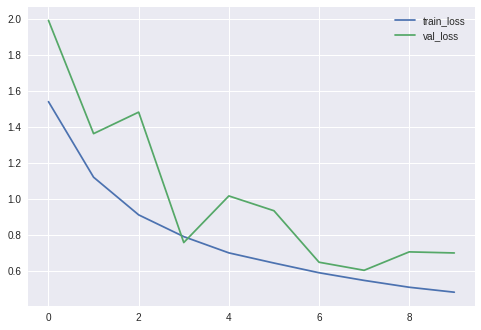

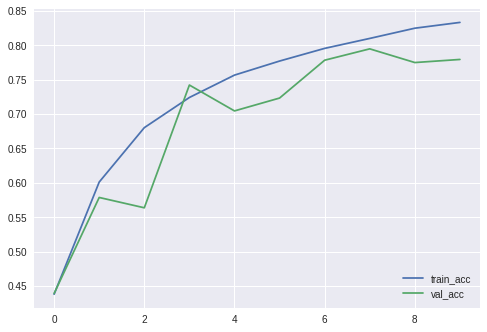

In [3]:
#cnnの構築
inputs = Input(shape=x_train.shape[1:])#横の数、縦の数、RGB

c = Conv2D(64, (1, 1), padding="same")(inputs)
c = BatchNormalization()(c)
c = Activation("relu")(c)
c = Conv2D(64, (3, 3), padding="same")(c)
c = BatchNormalization()(c)
c = Activation("relu")(c)
c = Conv2D(64, (3, 3), padding="same")(c)
c = BatchNormalization()(c)
c = Activation("relu")(c)
c = Conv2D(64, (3, 3), strides=2)(c)
c = BatchNormalization()(c)
c = Activation("relu")(c)

c = Conv2D(128, (3, 3), padding="same")(c)
c = BatchNormalization()(c)
c = Activation("relu")(c)
c = Conv2D(128, (3, 3), padding="same")(c)
c = BatchNormalization()(c)
c = Activation("relu")(c)
c = Conv2D(128, (3, 3), strides=2)(c)
c = BatchNormalization()(c)
c = Activation("relu")(c)

c = Conv2D(256, (3, 3), padding="same")(c)
c = BatchNormalization()(c)
c = Activation("relu")(c)
c = Conv2D(256, (3, 3), padding="same")(c)
c = BatchNormalization()(c)
c = Activation("relu")(c)
c = Conv2D(256, (3, 3), strides=2)(c)
c = BatchNormalization()(c)
c = Activation("relu", name="out")(c)

c = GlobalAveragePooling2D()(c)
c = Dense(classes, activation='softmax')(c)

model = Model(inputs, c)
#model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(amsgrad=True),
              metrics=['accuracy'])

# Data Augmentation
datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True)

datagen.fit(x_train)

#cnnの学習
hist = model.fit_generator(datagen.flow(x_train, Y_train, batch_size=128),
                           steps_per_epoch=len(x_train) / 128,
                           validation_data=(x_test, Y_test),
                           epochs=10)


#結果描画
plt.figure()               
plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.legend()
plt.show()

plt.figure()               
plt.plot(hist.history['acc'],label="train_acc")
plt.plot(hist.history['val_acc'],label="val_acc")
plt.legend(loc="lower right")
plt.show()

#関数もろもろ

In [0]:
#grad-CAM
def GradCam(model, x, layer_name, row, col):
    
    X = np.expand_dims(x,axis=0)
    
    # 前処理
    predictions = model.predict(X)
    class_idx = np.argmax(predictions[0])
    class_output = model.output[:, class_idx]
    
    # 勾配を取得
    conv_output = model.get_layer(layer_name).output   # layer_nameのレイヤーのアウトプット
    grads = K.gradients(class_output, conv_output)[0]  # gradients(loss, variables) で、variablesのlossに関しての勾配を返す
    gradient_function = K.function([model.input], [conv_output, grads])  # model.inputを入力すると、conv_outputとgradsを出力する関数

    output, grads_val = gradient_function([X])
    output, grads_val = output[0], grads_val[0]

    # 重みを平均化して、レイヤーのアウトプットに乗じる
    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # ヒートマップにして合成
    cam = cv2.resize(cam, (row, col), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    
    jetcam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # モノクロ画像に疑似的に色をつける
    jetcam = cv2.cvtColor(jetcam, cv2.COLOR_BGR2RGB)  # 色をRGBに変換
    jetcam = (np.float32(jetcam) + x*255 / 2)   # もとの画像に合成
    
    return array_to_img(jetcam), cam

#IOUの計算
def make_IOU(x, box):
    IOU_1, IOU_2 = 0, 0
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if x[i, j] == 1 or box[i, j] == 1:
                if x[i, j] == 1 and box[i, j] == 1:
                    IOU_1 += 1
                IOU_2 += 1
    IOU = IOU_1 / IOU_2
    return IOU

#ベイズ最適化でベストなボックスの探索
def make_box(x):
    def f(xx):
        x_begin, x_end, y_begin, y_end = xx[:,0], xx[:,1], xx[:,2], xx[:,3]

        # IOUの計算
        box = np.zeros(x.shape)
        box[int(y_begin):int(y_end),int(x_begin):int(x_end)] = 1
        IOU = make_IOU(x,box)
        #print("IOU", IOU)

        return -IOU

    bounds = [{'name': 'x_begin', 'type': 'continuous', 'domain': (0,x.shape[1]*0.75)},
              {'name': 'x_end', 'type': 'continuous', 'domain': (x.shape[1]*0.25, x.shape[1]-1)},
              {'name': 'y_begin', 'type': 'continuous', 'domain': (0,x.shape[0]*0.75)},
              {'name': 'y_end', 'type': 'continuous', 'domain': (x.shape[0]*0.25, x.shape[0]-1)}]

    #print("Bayesian Optimization")
    myBopt = GPyOpt.methods.BayesianOptimization(f=f, domain=bounds)
    myBopt.run_optimization(max_iter=10)

    #最適な座標の表示
    #print("Best position =")
    #print(myBopt.x_opt)

    #最適な座標の取得
    p = myBopt.x_opt
    x_begin, x_end, y_begin, y_end = p[0], p[1], p[2], p[3]
    box = np.zeros(x.shape)
    box[int(y_begin):int(y_end),int(x_begin):int(x_end)] = 1
    IOU = make_IOU(x,box)
    
    return int(x_begin), int(x_end), int(y_begin), int(y_end), IOU

#ヒートマップと画像の合成
def connect(x, heat):
    heat = cv2.applyColorMap(np.uint8(255 * heat), cv2.COLORMAP_JET)  # モノクロ画像に疑似的に色をつける
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)  # 色をRGBに変換
    heat = (np.float32(heat) + x*255 / 2)   # もとの画像に合成
    
    return array_to_img(heat)

#ボックスの生成（描画するだけ）

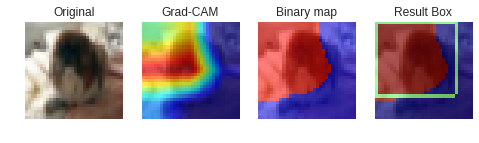

In [14]:
begin = 200
xx = []

#正解画像を取得
while True:
    predict = model.predict(np.expand_dims(x_test[begin],axis=0))
    if y_test[begin] == int(np.argmax(predict)):
        xx=x_test[begin]
        test_NO = begin
        break
    begin += 1

#元の画像を表示
plt.subplot(1,4,1)
plt.axis("off")
plt.title("Original")
plt.imshow(xx)
        
#grad-CAMの画像を表示
img, heat = GradCam(model, xx, "out", 32, 32)

plt.subplot(1,4,2)
plt.axis("off")
plt.title("Grad-CAM")
plt.imshow(img)

#二値化ヒートマップの画像を表示

#閾値より大きければ1、小さければ0にする
for k in range(heat.shape[0]):
    for l in range(heat.shape[1]):
        if heat[k,l] > 0.3:
            heat[k,l] = 1
        else:
            heat[k,l] = 0

heat_ = connect(xx, heat)

plt.subplot(1,4,3)
plt.axis("off")
plt.title("Binary map")
plt.imshow(heat_)

#ボックスの画像を表示
x_begin, x_end, y_begin, y_end, _ = make_box(heat)
heat_ = np.copy(heat)
heat_[y_begin, x_begin:x_end]=0.5
heat_[y_begin:y_end ,x_begin]=0.5
heat_[y_begin:y_end, x_end]=0.5
heat_[y_end, x_begin:x_end]=0.5
heat_ = connect(xx, heat_)

plt.subplot(1,4,4)
plt.axis("off")
plt.title("Result Box")
plt.imshow(heat_)

plt.show()

#連続してアノテーションデータを保存

##Googleドライブにマウント

In [0]:
from google.colab import drive
drive.mount('/content/drive')

##事前にAutoAnnotationというフォルダを作成してください。

In [15]:
%cd /content/drive//My Drive/AutoAnnotation

/content/drive/My Drive/AutoAnnotation


##xmlファイル、jpgの保存用関数

In [0]:
#xmlファイルの保存
def make_xml(jpg_name, label_name, width, height, xmin, ymin, xmax, ymax, f_name):

    xml_template = "<annotation>\
<filename>%s</filename>\
<source>\
<database>original</database>\
<annotation>original</annotation>\
<image>XXX</image>\
<flickrid>0</flickrid>\
</source>\
<owner>\
<flickrid>0</flickrid>\
<name>?</name>\
</owner>\
<size>\
<width> %d</width>\
<height> %d</height>\
<depth>3</depth>\
</size>\
<object>\
<name>%s</name>\
<pose>Unspecified</pose>\
<truncated>1</truncated>\
<difficult>0</difficult>\
<bndbox>\
<xmin> %d</xmin>\
<ymin> %d</ymin>\
<xmax> %d</xmax>\
<ymax> %d</ymax>\
</bndbox>\
</object>\
</annotation>"% (jpg_name, width, height, label_name, xmin, ymin, xmax, ymax)

    # xmlを保存
    dom = parseString(xml_template).toprettyxml(indent='  ')
    with open(f_name + '.xml', 'w') as f:
        f.write(dom)

    #dom = parseString(xml_template)
    #print (dom.toprettyxml())

#アノテーション付きの画像を表示
def fig_show(fig, x_begin, x_end, y_begin, y_end, jpg_name, label):
    fig[y_begin, x_begin:x_end, 0]=221/255
    fig[y_begin, x_begin:x_end, 1]=150/255
    fig[y_begin, x_begin:x_end, 2]=30/255
    fig[y_begin:y_end ,x_begin, 0]=221/255
    fig[y_begin:y_end ,x_begin, 1]=150/255
    fig[y_begin:y_end ,x_begin, 2]=30/255
    fig[y_begin:y_end, x_end, 0]=221/255
    fig[y_begin:y_end, x_end, 1]=150/255
    fig[y_begin:y_end, x_end, 2]=30/255
    fig[y_end, x_begin:x_end, 0]=221/255
    fig[y_end, x_begin:x_end, 1]=150/255
    fig[y_end, x_begin:x_end, 2]=30/255
    
    plt.imshow(fig)
    plt.title(label + ":" + jpg_name)
    plt.axis("off")
    plt.show()
    
#cifar10のラベル
labels = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck']

##DataAugmentationしながらアノテーションデータを保存

IOU: 0.6895910780669146


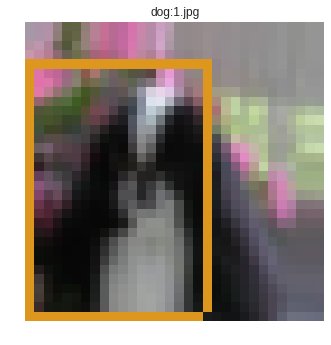

IOU: 0.755632582322357


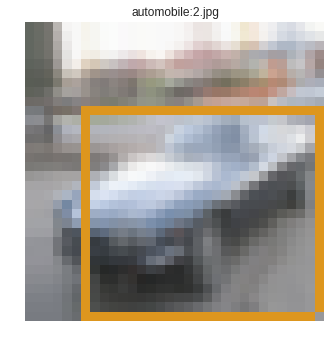

IOU: 0.9035532994923858


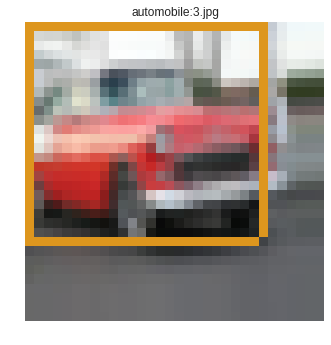

IOU: 0.6865482233502538


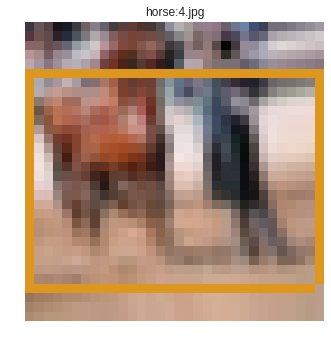

IOU: 0.849912739965096


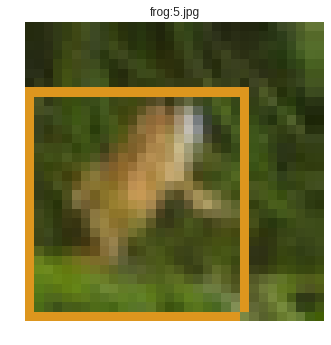

IOU: 0.6336633663366337


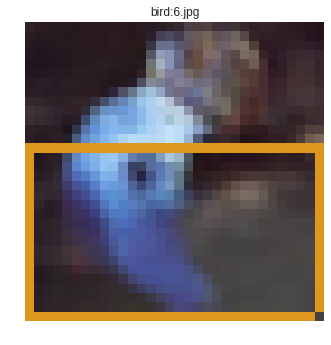

IOU: 0.9384765625


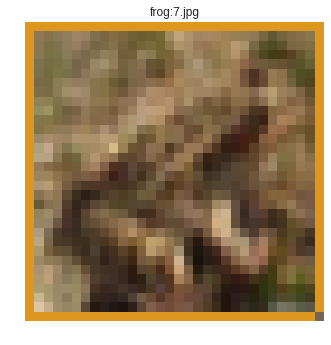

IOU: 0.7251908396946565


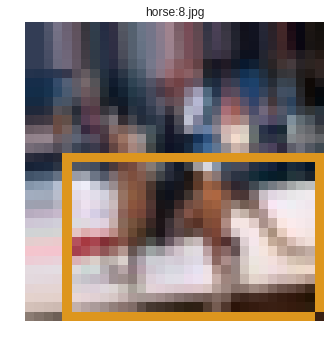

IOU: 0.9241830065359478


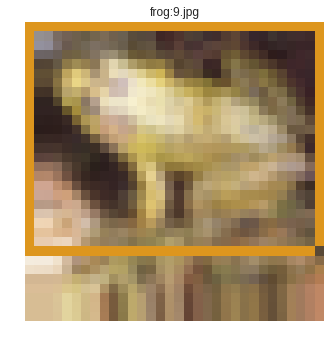

IOU: 0.6126878130217028


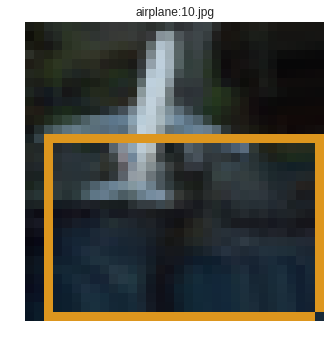

In [17]:
#保存フォルダの作成
a_path = "VOCdevkit/VOC2007/Annotations/"
txt_path = "VOCdevkit/VOC2007/ImageSets/Main/"
jpg_path = "VOCdevkit/VOC2007/JPEGImages/"

if not os.path.exists("VOCdevkit"):
    os.mkdir("VOCdevkit")
    os.mkdir("VOCdevkit/VOC2007")
    os.mkdir(a_path)
    os.mkdir("VOCdevkit/VOC2007/ImageSets")
    os.mkdir(txt_path)
    os.mkdir(jpg_path)

datagen = ImageDataGenerator(
           rotation_range=10,
           width_shift_range=0.1,
           height_shift_range=0.1,
           horizontal_flip=True,
           vertical_flip=False)


#連続してアノテーションデータを保存
NO_initial = 1 #始まりの番号
NO = np.copy(NO_initial)
num = 10 #データを何個生成するのか

while True:
    while True:
        for d, y in datagen.flow(x_test*255, y_test, batch_size=1):
            aug = d[0]/255
            break

        predict = model.predict(np.expand_dims(aug,axis=0))
        if y[0] == int(np.argmax(predict)):
            break

    fig = np.copy(aug)

    #grad-CAMの画像
    img, heat = GradCam(model, fig, "out", 32, 32)

    #二値化
    for k in range(heat.shape[0]):
        for l in range(heat.shape[1]):
            if heat[k,l] > 0.3:
                heat[k,l] = 1
            else:
                heat[k,l] = 0

    #ボックスの座標
    x_begin, x_end, y_begin, y_end, IOU = make_box(heat)
    
    #IOUが0.6以下のときはスルー
    if IOU > 0.6:
        print("IOU:",IOU)

        #アノテーション付きの画像を表示
        label = labels[y[0][0]]
        fig_show(fig, x_begin, x_end, y_begin, y_end, str(NO) + ".jpg", label)
      
        #xmlの保存
        make_xml(str(NO) + ".jpg", label, fig.shape[1], fig.shape[0],
                 x_begin, y_begin, x_end, y_end, a_path + str(NO))
      
        #jpgの保存
        save_img(jpg_path + str(NO) + ".jpg", aug)    

        NO += 1
        
    if NO - NO_initial ==  num:
        break

##的外れなjpgファイルを消して実行（不要なxmlの削除+trainval.txtの保存）

In [0]:
# ファイル名を取得
xml_files = glob.glob(a_path + '*.xml')
save_txt = []

#xmlの削除
for f in xml_files:
    xml_name = int(f[30:len(f)-4])
    jpg_name = jpg_path + str(xml_name) + ".jpg"
    if not os.path.exists(jpg_name):
        os.remove(f)
    else:
        save_txt.append(str(xml_name))

#最後にtrain.txtの保存
s = save_txt[0]

for i in range(1,len(save_txt)):
    s = s + "\n%s"%save_txt[i]

with open(txt_path + "trainval.txt", mode='w') as f:
    f.write(s)